In [237]:
from rich import print
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

### Defining a scalar function


In [3]:
def f(x):
    return 3 * x**2 - 4 * x + 5


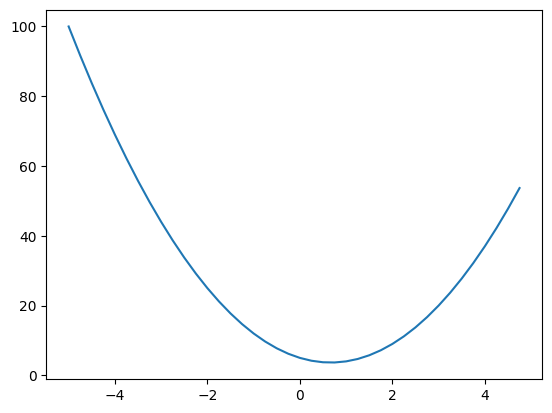

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)


### Defining the derivative


In [5]:
h = 1e-6
x = 2 / 3

(f(x + h) - f(x)) / h

2.999378523327323e-06

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c

print(d)


4.0

In [7]:
h = 1e-4
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c

# Calculate derivative w.r.t a
a += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
# this is just b (dd/da = b)
print("slope", (d2 - d1) / h)


d1 4.0

d2 3.999699999999999

slope -3.000000000010772

In [8]:
h = 1e-4
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
# Calculate derivative w.r.t b
b += h
d3 = a * b + c

print("d1", d1)
print("d3", d3)
# this is just a (dd/db = a)
print("slope", (d3 - d1) / h)


d1 4.0

d3 4.0002

slope 2.0000000000042206

In [9]:
h = 1e-4
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
# Calculate derivative w.r.t c
c += h
d4 = a * b + c

print("d1", d1)
print("d4", d4)
# this is just 1 (dd/dc = 1)
print("slope", (d4 - d1) / h)


d1 4.0

d4 4.0001

slope 0.9999999999976694

## Defining `Value`


In [342]:
class Value:
    def __init__(self, data, _children=(), _op="", label="") -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None  # function to calculate the local derivative
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            self.data + other.data,
            _children=(self, other),
            _op="+",
            label=f"({self.label} + {other.label})",
        )

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __radd__(self, other):  # other + self
        return self + other

    def __sub__(self, other):
        return self + (other * -1.0)

    def __rsub__(self, other):  # other - self
        return other + (self * -1.0)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            self.data * other.data,
            _children=(self, other),
            _op="*",
            label=f"({self.label} * {other.label})",
        )

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, degree):
        assert isinstance(degree, (int, float)), "Degree must be an int or float."

        x = self.data
        out = Value(x**degree, _children=(self,), _op=f"** {degree}")

        def _backward():
            self.grad += (degree * (x ** (degree - 1))) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), _children=(self,), _op="exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, _children=(self,), _op="tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def topological(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological(child)
                topo.append(v)

        topological(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [200]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")

d = a * b + c

a + 1, b * -3

(Value(data=3.0), Value(data=9.0))

In [51]:
print(d, d._prev, d._op)


Value(data=4.0)
{Value(data=10.0), Value(data=-6.0)}
+

### Visualizing the expression graph


In [66]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        # Iterate over a given node, check if it's already in the set of nodes, if not, add it
        if v not in nodes:
            nodes.add(v)
            # If node contains children, then 1. add an edge, 2. recursively look at the child nodes for their children
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)

    for n in nodes:
        # Generate unique identifier for each node
        uid = str(id(n))

        dot.node(
            uid,
            label=f"{{ {n.label} | data: {n.data:.4f} | grad: {n.grad:.4f} }}",
            shape="record",
        )

        if n._op:
            # If value is the result of an operation, add a node for it and an edge from the operation to the final value
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # For end node, add an edge from the intial value to the operator node, identified by the `uid` + `operator` [line 32]
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [67]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")

e = a * b
e.label = "e"

d = e + c
d.label = "d"

f = Value(-2.0, label="f")
L = d * f
L.label = "L"

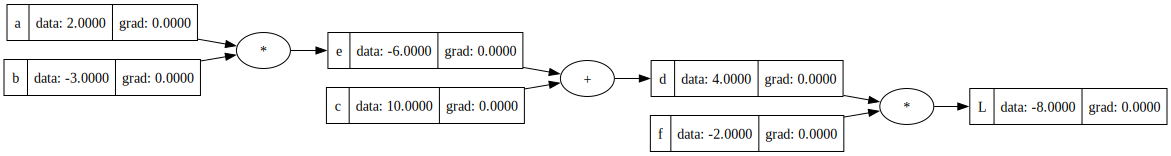

In [68]:
draw_dot(L)


### Manually building a neuron


In [167]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias
b = Value(6.88137, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"

x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"

y = x1w1x2w2 + b
y.label = "y"

# pass through activation function
o = y.tanh()
o.label = "o"

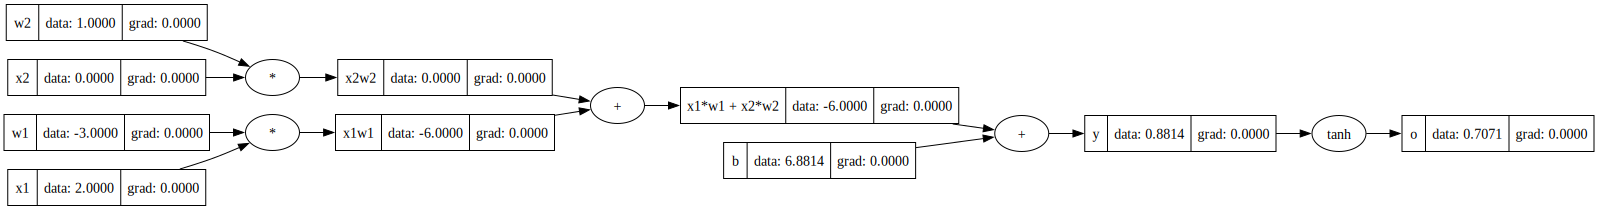

In [168]:
draw_dot(o)

##### Manually backpropagating

In [110]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [105]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [106]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [107]:
# o = tanh(y)
# do / dy = 1 - tanh(y)**2
y.grad = 0.5

In [108]:
o.grad = 1.0

##### Calling the `._backward()` method in the correct order (end to start)

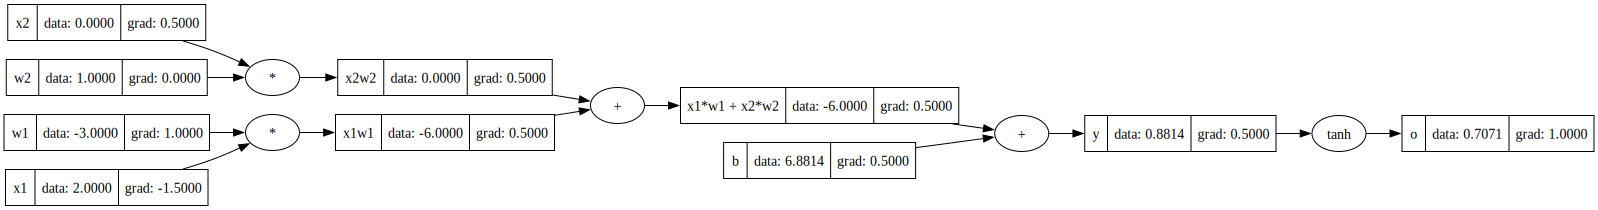

In [138]:
draw_dot(o)

In [130]:
o.grad = 1.0

In [131]:
o._backward()

In [133]:
y._backward()

In [135]:
b._backward()
x1w1x2w2._backward()

In [137]:
x1w1._backward()
x2w2._backward()

##### Calling the `._backward()` method automatically

In [156]:
# Implementing topological sorting (go from the end to the beginning, only one direction)
topo = []
visited = set()


def topological(v):
    # this does a depth-first search from the end node, looking at each of the previous nodes recursively and adding itself to the stack after processing all dependencies
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            topological(child)
        topo.append(v)

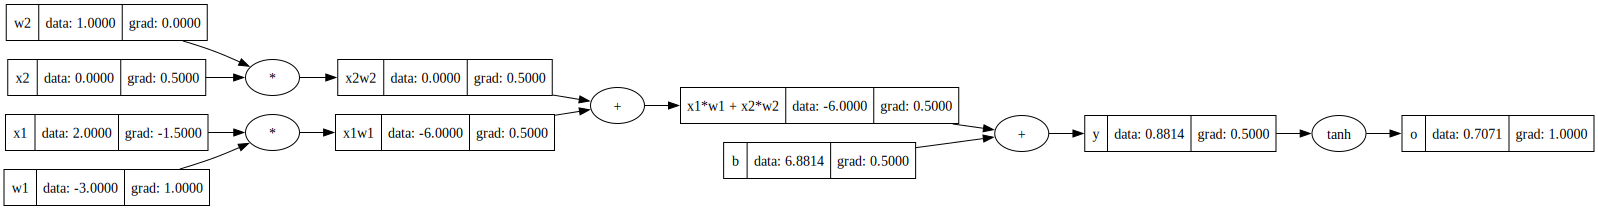

In [160]:
draw_dot(o)

In [158]:
topological(o)
print(topo, [t.label for t in topo])

[
    Value(data=0.0),
    Value(data=1.0),
    Value(data=0.0),
    Value(data=2.0),
    Value(data=-3.0),
    Value(data=-6.0),
    Value(data=-6.0),
    Value(data=6.88137),
    Value(data=0.8813700000000004),
    Value(data=0.7071049876722272)
]
['x2', 'w2', 'x2w2', 'x1', 'w1', 'x1w1', 'x1*w1 + x2*w2', 'b', 'y', 'o']

In [159]:
o.grad = 1.0
for node in reversed(topo):
    node._backward()

##### Cleanup 
This whole process of building a topological graph, starting from the root node, and calling the `._backward()` method on each node in the correct order will be moved into the `Value` class.

In [169]:
o.backward()

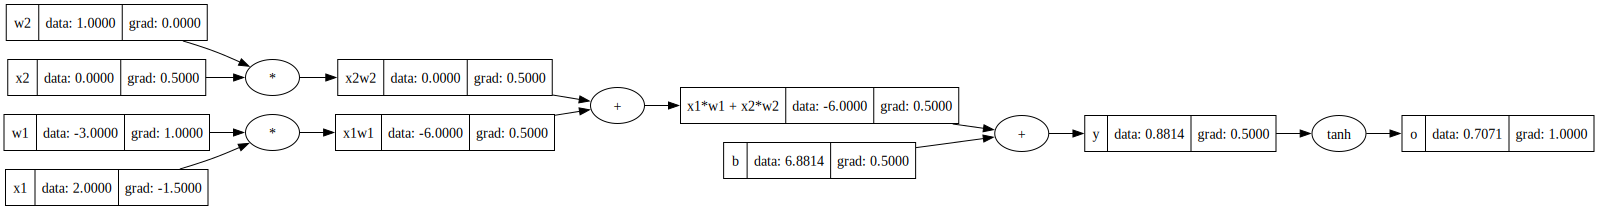

In [170]:
draw_dot(o)

#### Adding more operations

In [212]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias
b = Value(6.88137, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"

x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"

y = x1w1x2w2 + b
y.label = "y"

# pass through activation function (tanh = (e^2x - 1) / (e^2x + 1))
e = (2*y).exp()
e.label = "e^2y"

o = (e - 1) / (e + 1)
o.label = "o"

In [213]:
o.backward()

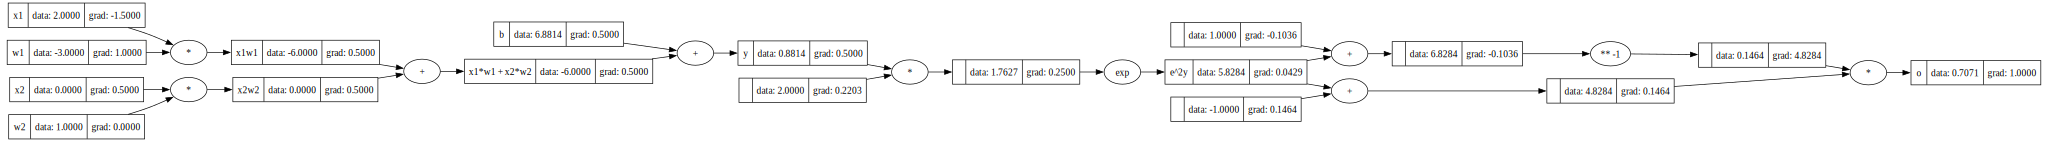

In [214]:
draw_dot(o)

### Comparing with PyTorch

In [222]:
import torch

In [226]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True

x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.88137]).double()
b.requires_grad = True

y = x1 * w1 + x2 * w2 + b
o = torch.tanh(y)

In [227]:
print(o.data.item())
o.backward()

print("---")
print("x2: ", x2.grad.item())
print("w2: ", w2.grad.item())
print("x1: ", x1.grad.item())
print("w1: ", w1.grad.item())

0.7071050214706146

---

x2:  0.5000024886110417

w2:  0.0

x1:  -1.500007465833125

w1:  1.0000049772220834

### Building a neural network with `Value` objects

In [409]:
class Neuron:
    def __init__(self, num_inputs) -> None:
        self.w = [Value(random.uniform(-1.0, 1.0)) for i in range(num_inputs)]
        self.b = Value(random.uniform(-1.0, 1.0), label="b")

    def __call__(self, x):
        activation = sum(((wi * xi) for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


x = [2.0, 3.0]

n = Neuron(2)

n(x)

Value(data=-0.7998745277695432)

In [416]:
class Layer:
    def __init__(self, num_inputs, num_outputs) -> None:
        self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


x = [2.0, 3.0]
l = Layer(2, 3)
l(x)
l.parameters()

[Value(data=0.5465690717873706),
 Value(data=0.30992001129084135),
 Value(data=-0.3155523497206967),
 Value(data=-0.15867525658560577),
 Value(data=-0.13065635954736643),
 Value(data=0.567939371580082),
 Value(data=0.7063372435687925),
 Value(data=0.32065907692071116),
 Value(data=-0.32176889372276163)]

In [476]:
class MLP:
    def __init__(self, num_inputs, num_layers) -> None:
        sz = [num_inputs] + num_layers
        # Layers of input size from the previous layer and output size from the next layer
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(num_layers))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [495]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])

mlp(x)

Value(data=0.5612025956219066)

In [496]:
# Inital parameters (random)
mlp.parameters()

[Value(data=-0.3542248110113295),
 Value(data=0.9558298000093681),
 Value(data=-0.8532305508115436),
 Value(data=0.13573288304693865),
 Value(data=-0.39328315980675965),
 Value(data=0.39953511510348183),
 Value(data=-0.0742362515558368),
 Value(data=0.6571662255560293),
 Value(data=0.3147628275888157),
 Value(data=0.07307005632544317),
 Value(data=-0.4655379181337973),
 Value(data=0.899683174645165),
 Value(data=0.010121309652489696),
 Value(data=0.12078105428070374),
 Value(data=0.25180381707729427),
 Value(data=-0.3463294650358102),
 Value(data=0.11624946566164485),
 Value(data=-0.6269821291351885),
 Value(data=0.4790406574850874),
 Value(data=0.16519509912238783),
 Value(data=-0.36686573117529875),
 Value(data=-0.2669887114401297),
 Value(data=0.9161701207627513),
 Value(data=0.5245225760472927),
 Value(data=0.2017877415422753),
 Value(data=-0.5981532415275173),
 Value(data=0.13859902417283032),
 Value(data=0.11269926124222485),
 Value(data=-0.11100763409378112),
 Value(data=-0.2338

### Training the neural network

In [497]:
xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, -1.0]

In [502]:
# Using MSE as loss function

ypreds = [mlp(x) for x in xs]

loss = sum([(y_i - yhat_i) ** 2 for y_i, yhat_i in zip(ys, ypreds)])
initial_loss = loss
loss


Value(data=7.197193529118911)

In [525]:
loss.backward()

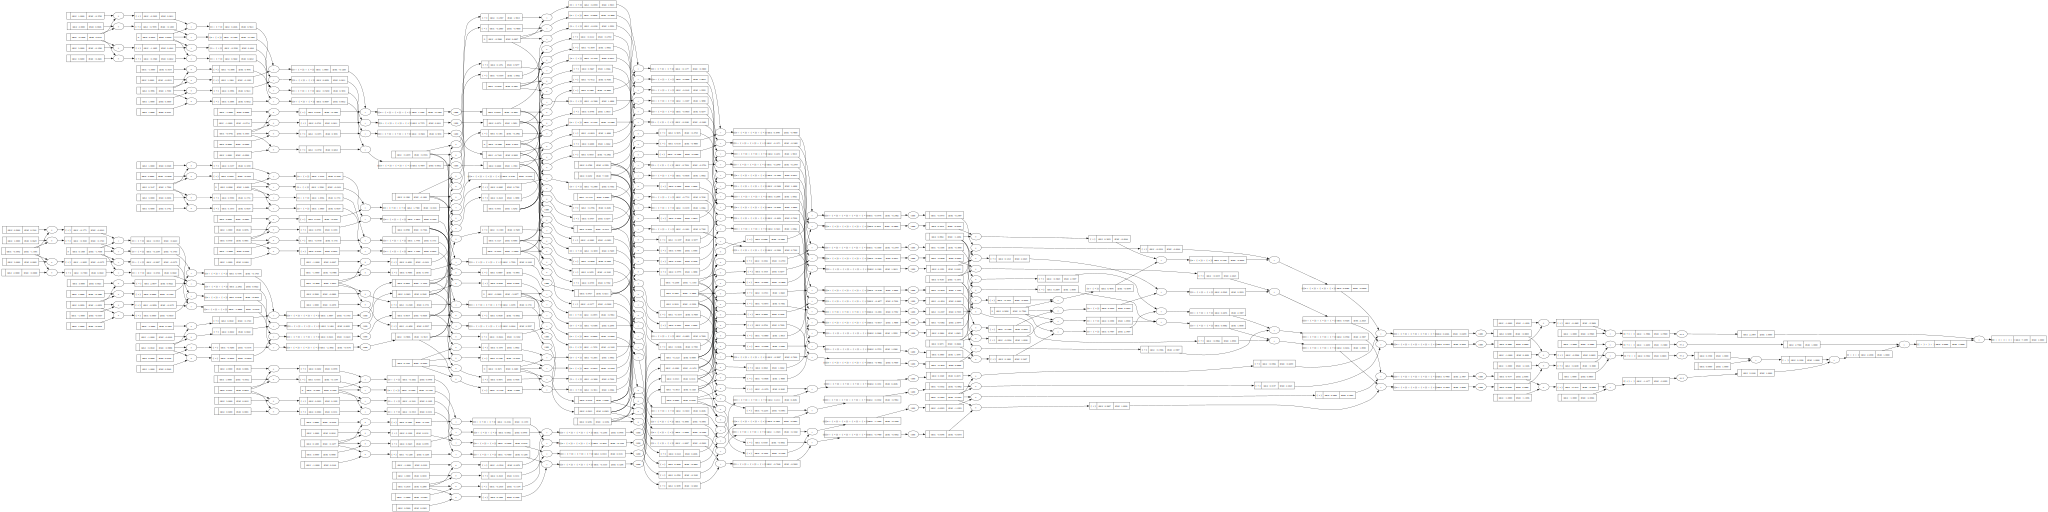

In [513]:
draw_dot(loss)

In [514]:
mlp.layers[0].neurons[0].w[0].grad

-1.1091133210379682

In [515]:
mlp.layers[0].neurons[0].w[0].data

-0.35416939369706957

In [526]:
for param in mlp.parameters():
    # Stochastic gradient descent
    # Gradient points in the direction of increasing the loss
    # To minimize, move in the opposite direction
    param.data += -1e-1 * param.grad

In [511]:
# After one step of gradient descent
ypreds = [mlp(x) for x in xs]
loss = sum([(y_i - yhat_i) ** 2 for y_i, yhat_i in zip(ys, ypreds)])

print(f"Initial loss: {initial_loss}")
print(f"Loss after 1 step of gradient descent: {loss}")

Initial loss: Value(data=7.197193529118911)

Loss after 1 step of gradient descent: Value(data=7.184943782186531)

#### Gradient descent
The above process of updating the weights in the opposite direction of the gradient is called gradient descent. After each iteration, the loss function is evaluated (forward propagation) and the gradients are computed (backward propagation). The weights are then updated in the opposite direction of the gradient. This process is repeated until the loss function converges to a minimum.

In [710]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])

mlp(x)

Value(data=-0.25046846324749755)

In [711]:
initial_params = mlp.parameters()
print(initial_params)

[
    Value(data=0.5038235899294516),
    Value(data=-0.8096136451677025),
    Value(data=-0.1308116649872475),
    Value(data=0.05642844517358059),
    Value(data=0.18612294497165283),
    Value(data=-0.18253680190474886),
    Value(data=-0.151102781892134),
    Value(data=0.31514315636538615),
    Value(data=-0.6593526316860088),
    Value(data=0.8773751687541775),
    Value(data=-0.833031521573051),
    Value(data=0.4839933664450913),
    Value(data=0.2179845346653635),
    Value(data=0.8902569404498992),
    Value(data=0.07646049028579105),
    Value(data=-0.21071952660915994),
    Value(data=0.5119639471302655),
    Value(data=-0.010479225621603305),
    Value(data=-0.7845981476694954),
    Value(data=0.41821190608315484),
    Value(data=0.4807404273345208),
    Value(data=-0.8848351188422015),
    Value(data=-0.9900315705616669),
    Value(data=-0.15440019936835458),
    Value(data=-0.31344228597212664),
    Value(data=0.9873711857628655),
    Value(data=0.422671885871889),
    Value(data=0.39895070183053005),
    Value(data=-0.4229806840168444),
    Value(data=0.8236761798933492),
    Value(data=-0.5102765015282629),
    Value(data=-0.03089001170438821),
    Value(data=0.006314082157032663),
    Value(data=0.9096109749099748),
    Value(data=-0.6098990184275024),
    Value(data=0.4745987474881628),
    Value(data=0.3665739293476804),
    Value(data=0.8810468763862234),
    Value(data=0.32873306081659903),
    Value(data=-0.6871907211157737),
    Value(data=-0.2439904949487004)
]

In [712]:
def gradient_descent(learning_rate, xs, ys, epochs):
    learning_rate = 1e-2
    losses = {}
    for k in range(epochs):
        # forward pass
        ypreds = [mlp(x) for x in xs]
        loss = sum([(y_i - yhat_i) ** 2 for y_i, yhat_i in zip(ys, ypreds)])
        losses[k] = loss

        # backward pass
        for param in mlp.parameters():
            param.grad = 0.0

        loss.backward()

        # update parameters
        for param in mlp.parameters():
            param.data += -learning_rate * param.grad

        # print(k, loss.data)

    return losses, params


losses, params = gradient_descent(1e-1, xs, ys, 20)

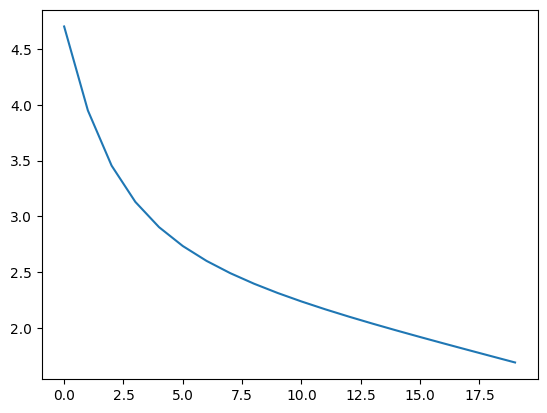

In [713]:
# plot losses
plt.plot(list(losses.keys()), list(l.data for l in losses.values()))

In [714]:
# Optimal parameters
print(mlp.parameters())

[
    Value(data=0.5608123708219866),
    Value(data=-0.7563754630000881),
    Value(data=-0.14576333081454546),
    Value(data=0.13905138689494323),
    Value(data=0.1886849799543926),
    Value(data=-0.3111191130235517),
    Value(data=-0.022912008409087886),
    Value(data=0.4132908899943101),
    Value(data=-0.5560289569511152),
    Value(data=1.0670043438478023),
    Value(data=-0.6471650881013024),
    Value(data=0.6820634174148184),
    Value(data=0.05281964466958705),
    Value(data=0.7947036302792824),
    Value(data=-0.05481047818902465),
    Value(data=-0.3846687350692869),
    Value(data=0.4769480070272978),
    Value(data=-0.022890957545825052),
    Value(data=-0.7468529517247621),
    Value(data=0.45271992712950265),
    Value(data=0.46453655771071667),
    Value(data=-0.9876070446479773),
    Value(data=-1.0816502910676464),
    Value(data=-0.10495180839753934),
    Value(data=-0.2654631636962556),
    Value(data=0.8343358923855722),
    Value(data=0.3433614711331727),
    Value(data=0.36063994496120005),
    Value(data=-0.34113487713369983),
    Value(data=0.8963649416893926),
    Value(data=-0.5402228794393895),
    Value(data=0.08862483510348594),
    Value(data=0.07635311230485957),
    Value(data=0.7679294056709403),
    Value(data=-0.7181085263911384),
    Value(data=0.5514190824895627),
    Value(data=0.14756691387359283),
    Value(data=0.9872083150008805),
    Value(data=0.3396306658773541),
    Value(data=-0.6846056398672451),
    Value(data=-0.3570627679873279)
]

In [716]:
ypreds = [mlp(x) for x in xs]
ypreds

[Value(data=0.028682476944782338),
 Value(data=-0.853252654540934),
 Value(data=-0.2612401226922752),
 Value(data=-0.6529885026398868)]

In [718]:
sum([(y_i - yhat_i) ** 2 for y_i, yhat_i in zip(ys, ypreds)])

Value(data=1.6311756496132381)